In [1]:
import math
import numpy as np
import pylab as plt
plt.style.use('./matplotlib.style')
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage
import scipy.io
from tqdm import tqdm
from utils import getR
import sys
sys.path.append('./pytorch_nufft')
from pytorch_nufft import nufft
from typing import Callable

gyromagnetic_ratio = 42.58 # MHz / T ~ kHz / mT

from typing import List, Tuple
def gtime(seq: List[Tuple]):
    res = []
    t = 0
    for (dt, n) in seq:
        res.append(np.linspace(t, t + dt * n, n))
        t = t + dt * n
    return np.concatenate(res)


def blochEquationLaboratoryStep(M: torch.Tensor, Rfunc: Callable, M0: torch.Tensor, T1: torch.Tensor, T2: torch.Tensor, dt: float, step: int):
    # rotating
    M = torch.matmul(Rfunc(step), M.T[:, :, None])[:, :, 0].T
    # time relaxation
    M[0] = M[0] * torch.exp(-dt / T2)
    M[1] = M[1] * torch.exp(-dt / T2)
    M[2] = M[2] * torch.exp(-dt / T1) + M0 * (1 - torch.exp(-dt / T1))
    return M

def blochEquationRotatingStep(M: torch.TensorType, Rfunc: Callable, M0: torch.Tensor, T1: torch.Tensor, T2: torch.Tensor, B0: torch.Tensor, dt: float, step: int):
    # rotating
    M = torch.matmul(Rfunc(step), M.T[:, :, None])[:, :, 0].T
    # back to laboratory frame
    # Mxy = (M[0] + 1j * M[1]) * (-2j * math.pi * B0 * gyromagnetic_ratio * dt).exp()
    # M[0] = Mxy.real
    # M[1] = Mxy.imag
    # time relaxation
    M[0] = M[0] * torch.exp(-dt / T2)
    M[1] = M[1] * torch.exp(-dt / T2)
    M[2] = M[2] * torch.exp(-dt / T1) + M0 * (1 - torch.exp(-dt / T1))
    return M

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img = torch.from_numpy(skimage.data.astronaut() * 1.0)[::2, ::2].float()
img *= 1. / img.max()
print(img.shape)
rho_map = img[:,:,0]
t1_map = img[:,:,1] * 3000 + 1000
t2_map = img[:,:,2] * 1000 + 1000

torch.Size([256, 256, 3])


In [3]:
dt = 1 / (2 * gyromagnetic_ratio * 1600)
Nt = 256 / (gyromagnetic_ratio * 200 * dt)
dt, Nt

(7.339126350399249e-06, 4096.0)

In [6]:
num_isochromats_per_voxel = 1
phases = torch.linspace(-.85, .85, 256)[:, None, None]

T1 = t1_map.flatten().repeat(num_isochromats_per_voxel * phases.shape[0])
T2 = t2_map.flatten().repeat(num_isochromats_per_voxel * phases.shape[0])
M = rho_map.flatten()[None, :].repeat(3, num_isochromats_per_voxel * phases.shape[0])
# M[:2] = 0

M = torch.ones_like(M)
M[1:] = 0

M += torch.rand_like(M) * 1e-3
M0 = M[2].clone()
efm = []

# B1 field [mT]
x = torch.linspace(-1.0, 1.0, 256) # x [m]
y = torch.linspace(-1.0, 1.0, 256) # y [m]
X, Y = torch.meshgrid(x, y, indexing='ij')
Gx = X[None, :, :] * torch.ones_like(phases)
Gx *= 100
Gx = Gx.flatten()[None, :].repeat(3, num_isochromats_per_voxel)
Gx[:2] = 0
Gy = Y[None, :, :] * phases
Gy *= 100
Gy = Gy.flatten()[None, :].repeat(3, num_isochromats_per_voxel)
Gy[:2] = 0


# B0 field [mT]
B0 = torch.ones_like(M) * 1500
B0[:2] = 0

B0 = B0.cuda()
Gx = Gx.cuda()
Gy = Gy.cuda()
M = M.cuda()
M0 = M0.cuda()
T1 = T1.cuda()
T2 = T2.cuda()

# relax
dt = 1e-5       # [ms]
# R = getR(B0, dt)
R = getR(B0 - torch.tensor([0.,0.,1500. + 1e-3], device=B0.device)[:, None], dt)
for i in tqdm(range(15)):
    # M = blochEquationLaboratoryStep(M, lambda i: R, M0, T1, T2, dt, i)
    M = blochEquationRotatingStep(M, lambda i: R, M0, T1, T2, B0[2], dt, i)
    efm += [M.reshape(3, phases.shape[0], -1)[:, 0, 0].cpu().numpy()]

efm = torch.from_numpy(np.array(efm)).float()

100%|██████████| 15/15 [00:00<00:00, 29.09it/s]


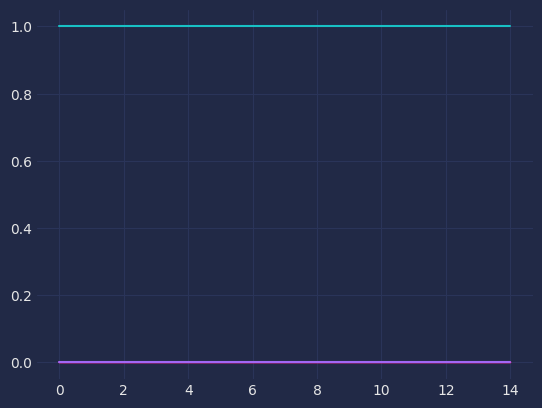

In [7]:
plt.plot(efm[:, 0])
plt.plot(efm[:, 1])
plt.plot(efm[:, 2])
plt.show()